In [1]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py
import datetime

In [2]:
f = h5py.File("test.hdf5", "r")

In [3]:
s = np.sort(np.random.choice(570,5))
cur = list(f)[0]
print(s)
val = f[str(cur)][list(s)]
val

[ 38  46 252 521 539]


array([[ 0.11157567,  0.137669  ,  0.10501419, ...,  0.25302896,
         0.22626422,  0.19336528],
       [ 0.0753502 ,  0.06106754,  0.03946043, ...,  0.13895078,
         0.09674367,  0.08380383],
       [ 0.25974303,  0.29914242,  0.34186834, ...,  0.18457595,
         0.10690634,  0.01052889],
       [ 0.34550005,  0.28193   ,  0.22595905, ..., -0.04342784,
        -0.03244118, -0.05041658],
       [ 0.00122074,  0.01904355,  0.06198309, ...,  0.05722221,
         0.05734428, -0.00476089]], dtype=float32)

In [4]:
NUM_FP = f['10'].shape[0]
LENGTH = f['10'].shape[1]
PER_MUSIC = 4
NUM_LABEL = 16
ANCHOR_LEN = 8

def get_batch(f, k=64, shuffle=True, actual_label=False):
    ##f: hdf5 file object
    
    # initialize array
    batch = []
    label = []

    # get the anchor label
    anchor = np.random.choice(len(f), 1)[0]
    
    # get different negative labels
    labels = np.random.choice(len(f), NUM_LABEL-ANCHOR_LEN//PER_MUSIC)
    while np.any(labels == anchor):
        labels = np.random.choice(len(f), NUM_LABEL-ANCHOR_LEN//PER_MUSIC)
    
    # get 8 positive data (consecutive segments within 400 ms)
    cur_label = list(f)[anchor]
    num_fp = f[cur_label].shape[0]
    start = np.random.choice(num_fp-ANCHOR_LEN, 1)[0] # get start point of the segments
    batch.append(f[cur_label][start:start+ANCHOR_LEN//2])
    batch.append(f[cur_label][start+ANCHOR_LEN//2:start+ANCHOR_LEN])
    if actual_label:
        label += [int(cur_label)] * ANCHOR_LEN
    else:
        label += [0] * ANCHOR_LEN
    
    # get negative data
    for i in range(len(labels)):
        cur_label = list(f)[labels[i]]
        num_fp = f[cur_label].shape[0]
        rand = np.sort(np.random.choice(num_fp, PER_MUSIC, replace=False))
        val = f[cur_label][list(rand)]
        batch.append(val)
        label += list(np.arange(PER_MUSIC)+i*PER_MUSIC)
    
    batch = np.asarray(batch)
    batch = batch.reshape(PER_MUSIC*NUM_LABEL, LENGTH)
    label = np.asarray(label)

    # shuffle all samples
    if shuffle:
        s = np.arange(batch.shape[0])
        np.random.shuffle(s)
        batch = batch[s]
        label = label[s]
    
    # create k-size batches
    batch = batch[:k]
    label = label[:k]
    batch = batch.reshape(k, LENGTH, 1)

    return np.asarray(batch), np.asarray(label)

In [5]:
start = datetime.datetime.now()
train_data, train_label = get_batch(f)
end = datetime.datetime.now()
print(train_label)
print(end-start)

[29 54 14 43 25  0 44  0  0 28  9 33 46  8 17 19  0 49 37  7 55 12 47 36
 22 13 52 24  0 45 51  0 32 18 42 34  1  0 10 48 41 30  5 50 40 21 53 16
 31  2 15  4  0 27  0 20 35 26 38 39 23  6 11  3]
0:00:00.778346


In [6]:
np.amin(train_data)

-1.0665594

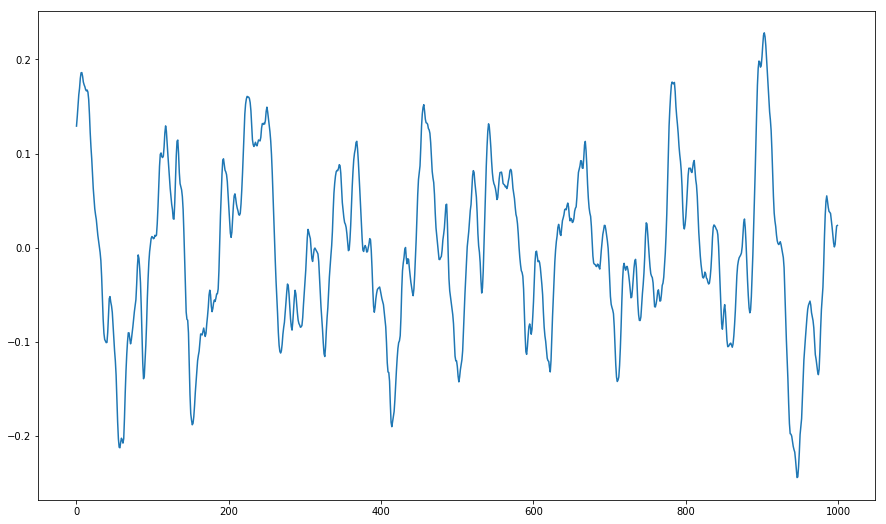

In [7]:
plt.figure(figsize=(15,9))
plt.plot(train_data[0][:1000])

In [8]:
MARGIN = 0.1

# helper function for triplet loss
def dist(x,y):
    diffs = tf.expand_dims(x, axis=1) - tf.expand_dims(y, axis=0)
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)

def triplet_loss(dists, labels):
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)

In [9]:
"""Define functions to create the triplet loss with online triplet mining."""

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

In [10]:
NUM_EMBEDDING = 64
SPLIT = 8

def model(features):
    # convolution layer 1 
    conv1 = tf.layers.conv1d(
        inputs=features,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2)
    
    # convolution layer 2 
    conv2 = tf.layers.conv1d(
        inputs=pool1,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2)
    
    # convolution layer 3 
    conv3 = tf.layers.conv1d(
        inputs=pool2,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 3
    pool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2)
    
    # flatten input: 16*64=1024
    flat = tf.layers.flatten(pool3)
    
    drop = tf.layers.dropout(flat)

    # divide and encode
    concatenate = []
    num_each_split = drop.shape[-1]//SPLIT
    units = NUM_EMBEDDING//SPLIT
    splits = tf.split(drop, SPLIT, 1)

    divides = []
    for i in range(SPLIT):
        divide = tf.layers.dense(splits[i], activation=tf.nn.relu, units=128)
        divide = tf.layers.dense(divide, units=units)
        concatenate.append(divide)
        divides.append(divide)
    
    embedding = tf.concat([elem for elem in concatenate], 1)

    return embedding

In [12]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, LENGTH, 1])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
embedded = model(input_data)
#embedded = tf.debugging.check_numerics(embedded, 'embedded data has nan!')
#dists = dist(embedded, embedded)
loss, _dis = batch_all_triplet_loss(input_label, embedded, MARGIN, squared=True)
#loss = tf.reduce_mean(triplet_l)

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001)
#variables = tf.trainable_variables()
#gradients = optimizer.compute_gradients(loss, variables)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling1d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [24]:
num_epoch = 15000
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
loss_hist = []
    
start = datetime.datetime.now()
for i in range(num_epoch):
    train_data, train_label = get_batch(f)
    _, loss_val, embedding = sess.run([train_op, loss, embedded],
                           feed_dict={input_data: train_data,
                                      input_label: train_label})
    loss_hist.append(loss_val)
    if i % 100 == 0:
        print('iter num: '+str(i)+' loss: '+str(loss_hist[-1]))
    #print('embedding: '+str(embedding))
end = datetime.datetime.now()
print('time: '+str(end-start))

iter num: 0 loss: 0.12607935
iter num: 100 loss: 0.081316955
iter num: 200 loss: 0.078371175
iter num: 300 loss: 0.06951775
iter num: 400 loss: 0.08974425
iter num: 500 loss: 0.10226503
iter num: 600 loss: 0.08468006
iter num: 700 loss: 0.07927368
iter num: 800 loss: 0.07252415
iter num: 900 loss: 0.07007807
iter num: 1000 loss: 0.06331194
iter num: 1100 loss: 0.08533154
iter num: 1200 loss: 0.061678514
iter num: 1300 loss: 0.06433754
iter num: 1400 loss: 0.09402947
iter num: 1500 loss: 0.12530589
iter num: 1600 loss: 0.07912185
iter num: 1700 loss: 0.053240865
iter num: 1800 loss: 0.069180995
iter num: 1900 loss: 0.108763546
iter num: 2000 loss: 0.16780107
iter num: 2100 loss: 0.08493889
iter num: 2200 loss: 0.071245946
iter num: 2300 loss: 0.11319442
iter num: 2400 loss: 0.066315696
iter num: 2500 loss: 0.046304945
iter num: 2600 loss: 0.12992902
iter num: 2700 loss: 0.140926
iter num: 2800 loss: 0.1018941
iter num: 2900 loss: 0.09768323
iter num: 3000 loss: 0.09512674
iter num: 3100

In [25]:
saver = tf.train.Saver()
save_path = saver.save(sess, "../model/64_batch")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/64_batch


first five embeddings: [-0.05076113  0.04226505 -0.1770966  -0.2700994   0.06245401 -0.01568844
 -0.21450919 -0.06851096 -0.20247425 -0.16529562  0.09790707  0.07797705
 -0.13846363 -0.03964128 -0.04558721  0.11244936  0.13021459 -0.02985318
  0.07783557  0.03013935  0.2840987  -0.06472158 -0.21423344 -0.05427446
  0.08971407 -0.07431622 -0.15259317 -0.1254148  -0.02006726  0.12028075
  0.01189132  0.09412347 -0.03622465  0.1263534  -0.0067176  -0.07135566
 -0.00183415 -0.01911857 -0.04631061  0.1002335   0.05287452  0.01613089
  0.05938415  0.04050867 -0.21841116 -0.00108539 -0.03391786  0.05004351
  0.01427307  0.08229552 -0.04125066 -0.01790178 -0.10294731  0.04348423
  0.04786678  0.0350433   0.01509598  0.01617852  0.07019202  0.12520513
  0.08260698  0.1137943  -0.01123919 -0.04333524]

first ten labels: [34 20 22  2 49  0 29  6 36 25 37 28  0  8 38 31 52  0 51  1 10 27 48  0
 46 19 23 24 18  0 47 30  9 13 45  3  0  4 55 42 50 53 35 21 39 16 15 14
  0 12 33 17 40 41 26  5 43  7 3

Text(0.5, 1.0, 'loss history')

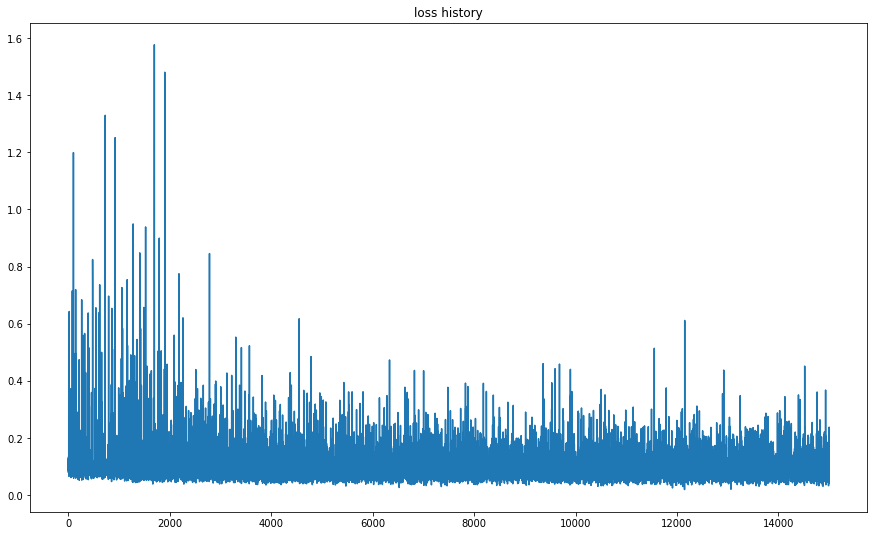

In [26]:
train_data, train_label = get_batch(f)
embeddings = sess.run([embedded], feed_dict={input_data: train_data})
print('first five embeddings: '+str(embeddings[0][0]))
print('\nfirst ten labels: '+str(train_label))
plt.figure(figsize=(15,9))
plt.plot(loss_hist)
plt.title('loss history')

In [27]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 
    
#tvars = tf.trainable_variables()
#for var, grads in zip(tvars, grad):
#    print(var.name, grads) 

conv1d/kernel:0 [[[-0.21150124 -0.01591806 -0.2112589   0.00239183 -0.1672875
    0.2199416  -0.04179715  0.01631446 -0.20230636  0.04852999
    0.0676799  -0.05234481  0.05617312 -0.04224033 -0.04853097
   -0.01923798  0.07807537 -0.13812137 -0.1401802  -0.23061688
    0.16666251 -0.01598006 -0.14958417 -0.23721454  0.18566516
    0.02494688 -0.17159945 -0.20612055  0.00807048  0.2250032
    0.14548959 -0.07665052]]

 [[-0.1575083   0.16796204 -0.14120184 -0.13369626  0.04041177
    0.00426484 -0.16477542 -0.0221336   0.19151308  0.14573275
    0.08300681  0.1888723   0.12718126 -0.21270321 -0.23536204
   -0.18319142 -0.1508504  -0.07840848  0.15140004  0.05538185
    0.22083806 -0.04111187  0.17900488 -0.13098443 -0.08206355
   -0.22347149  0.12057222 -0.22033882 -0.10730562 -0.08468129
    0.09078649 -0.14597575]]

 [[-0.06229665 -0.01284622 -0.16515732  0.08147244 -0.001188
    0.03952767 -0.00773556 -0.22550039  0.14272416 -0.24083398
   -0.19620176 -0.22717893 -0.17525311  0.0254

In [28]:
threshold = 10 # threshold to get the similarity
top_k = 10 #
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim

def get_track(music):
    ##music: the music to find the name
    batch = []
    temp = np.array(music.get_array_of_samples())
    # check if the audio has two channels
    if len(temp) > INPUT_LEN: 
        temp = [temp[i] for i in range(0,len(temp),2)] #get left channel only
    
    # convert to fingerprints
    num_fp = int((len(temp)-LENGTH)/INTERVAL)+1
    for j in range(num_fp):
        segment = temp[j*INTERVAL:j*INTERVAL+LENGTH]
        cur_spec, freqs, bins, im = plt.specgram(segment, Fs=Fs)
        cur_spec = cur_spec[:WIDTH, :HEIGHT] #truncate to power of 2            
        batch.append(cur_spec)
        
    simvec = []
    for i in range(len(batch)):
        cur_vec = similarity(batch[0], data_base)

In [29]:
simvec = similarity(embedding[0], embedding)
mostsims = np.argsort(-simvec)[:4]
labelsame = np.where(train_label == train_label[0])
print(labelsame)
print(mostsims)

(array([0]),)
[ 0 50 45 58]


In [14]:
tf.test.is_gpu_available()

True